In [1]:
import numpy as np
import glob
import os 
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
import pandas as pd

In [2]:
def getChi(data):
    N = data.shape[0]
    t_max = data.shape[1]
    cov = 1/t_max * (data @ data.T) # NxN
    # print(cov.shape)
    mu = np.mean(data, axis=1) # Nx1
    m_ij = np.outer(mu, mu)
    # print(m_ij.shape)
    c = cov - m_ij # NxN
    # print(np.sum(cov))
    # chiSG = np.sum(c**2, axis=1)
    # chiUni = np.sum(c, axis=1)
    chiSG = np.sum(c**2) / N
    # print(chiSG)
    chiUni = np.sum(c) /N
    # l, _ = np.linalg.eig(cov)
    # chiSG = np.dot(l, l) / N;
    # print(chiSG, chiUni)
    return chiSG, chiUni, c, cov, mu

In [8]:
z_ts_files = glob.glob('data/input_data/ADNI/parcellated_z_output/*_z_timeseries.txt')
timeseries = [np.loadtxt(i) for i in z_ts_files]
timeseries = np.array(timeseries)
print(timeseries[0].shape)


(140, 116)


/tmp/ipykernel_586/457179834.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeseries = np.array(timeseries)


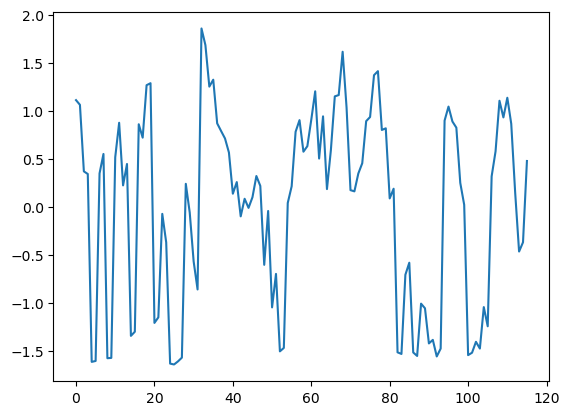

In [11]:
idx = 0
r_idx = 0
k = timeseries[idx][r_idx, :]
plt.plot(timeseries[idx][ r_idx, :])

(array([24.,  7.,  4.,  5., 10., 20., 14., 21.,  8.,  3.]),
 array([-1.64467983, -1.29475885, -0.94483788, -0.5949169 , -0.24499593,
         0.10492505,  0.45484603,  0.804767  ,  1.15468798,  1.50460896,
         1.85452993]),
 <BarContainer object of 10 artists>)

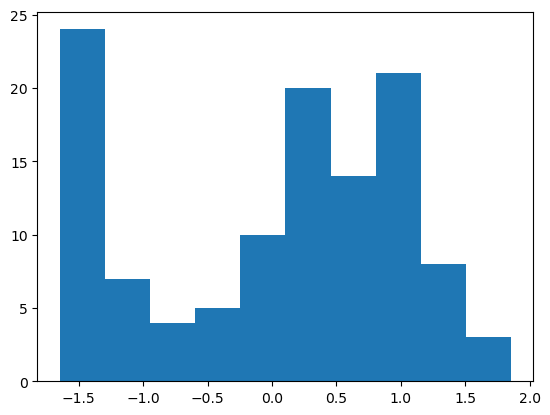

In [13]:
dS = k - np.mean(k)
plt.hist(dS)

In [33]:
def autocorr(x):
    xp = x - np.mean(x)
    n = len(x)
    f = np.fft.fft(xp, n*2)
    acf = np.real(np.fft.ifft(f * np.conjugate(f))[:n])
    # acf /= (4*np.var(x))
    acf /= acf[0]
    return acf

from scipy.optimize import curve_fit

def exp_decay(t, tau, A, B=0):
    """
    Exponential decay function.
    """
    return A * np.exp(-t/tau) + B

def relaxation_time(x, t, t_max=None):
    if t_max is None:
        t_max = len(t) // 10
    p0 = [t[t_max], x[0]]
    func = lambda t, tau, A: exp_decay(t, tau, A, B=np.mean(x[50:]))
    popt, pcov = curve_fit(func, t[:t_max], x[:t_max], p0=p0)
    tau = popt[0]
    A = popt[1]
    B = np.mean(x[50:])
    return tau, A, B

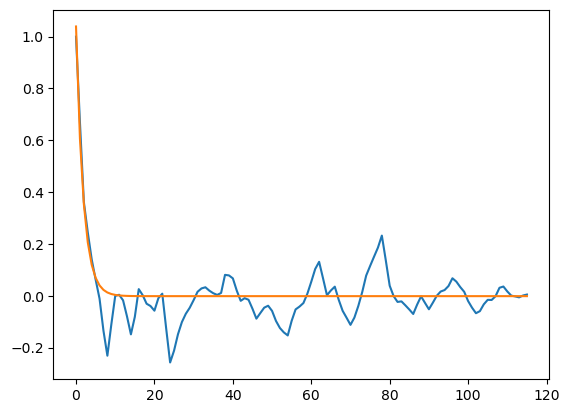

In [34]:
for sub in range(timeseries.shape[0]):
    act = autocorr(k)
    tau, A, B = relaxation_time(act, np.arange(len(act)))
    plt.plot(act)
    plt.plot(np.arange(len(act)), exp_decay(np.arange(len(act)), tau, A, B))

In [35]:
tau

1.8602850820304493

In [ ]:
gs_timeseries = []
for fn in z_ts_files:
    sub = fn.split('_z_timeseries')[0]
    gs_file = sub+'_gs.txt'
    gs = np.loadtxt(gs_file)
    gs_timeseries.append(gs)

In [4]:
datalen = [i.shape[0] for i in timeseries]
datalen = np.array(datalen)
t_max = range(130, 145, 1)
count = []
for t in t_max:
    c = np.sum(datalen > t)
    count.append(c)
# plt.plot(t_max, count)
t_max = t_max[::-1]
count = count[::-1]
# print(list(t_max))
# print(count)
count = np.array(count)
idx = np.argmax(count > 80)
print(t_max[idx])
print(count[idx])
max_t = t_max[idx]

139
89


In [5]:
rois = 116
data_trunc = [] 
thresholds = {}

subids = []
for i in z_ts_files: 
    subid = os.path.basename(i).split('z')[0][:-1]
    subids.append(subid)


In [6]:
trunc_subids = []
for idx, i in enumerate(timeseries):
    if i.shape[0] < max_t or i.shape[1] != rois:
        print('skipping', subids[idx])
        continue
    trunc_subids.append(subids[idx])
    trunc = i[:max_t, :]
    trunc = trunc - np.mean(trunc, axis=0)
    s_max = np.max(trunc)
    s_min = np.min(trunc)
    # print(s_max, s_min)
    # point at which the line connecting (s_min, -1) and (s_max, 1) meets x-axis
    thres = (s_max + s_min) / 2
    thresholds[subids[idx]] = thres
    # plt.plot(trunc[:, 0])
    # plt.axhline(y=thres, color='black', linestyle='--')
    # plt.show()
    # print(thres)
    binarized = np.where(trunc > thres, 1, -1)
    # print(binarized.shape)
    data_trunc.append(binarized.T) 
    # plt.plot(data_trunc[-1][0])
    # plt.show()
#     data_trunc.append(trunc) 
data_trunc = np.array(data_trunc)
print(data_trunc.shape)

skipping 002_S_4262
(88, 116, 139)


In [40]:
data_concat = np.concatenate(data_trunc, axis=1)
print(data_concat.shape)
np.savetxt('data/adni_z_concat.txt', data_concat)

(116, 12232)


(88,)


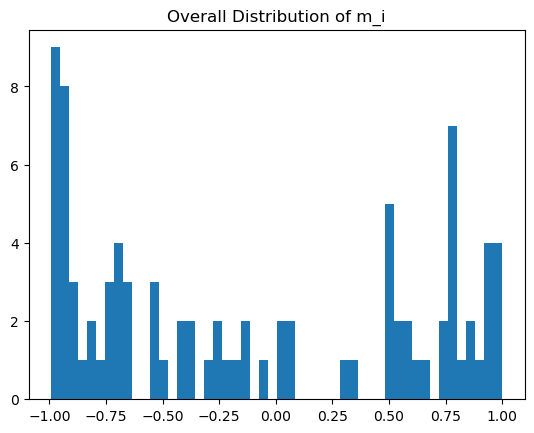

In [13]:
m = np.mean(data_trunc[2], axis=1)
m_subs = [np.mean(i) for i in data_trunc]
m_subs = np.array(m_subs)
# print(m[0])
print(m_subs.shape)
# m_subs = np.reshape(m_subs, -1)
plt.hist(m_subs, bins=50)
plt.title('Overall Distribution of m_i')
plt.show()

In [15]:
res = np.zeros((data_trunc.shape[0], 5), dtype=object)
for i in range(data_trunc.shape[0]):
    res[i][0], res[i][1], res[i][2], res[i][3], res[i][4] = getChi(data_trunc[i])

In [16]:
c = [i[2] for i in res]
cov = [i[3] for i in res]
m = [i[4] for i in res]

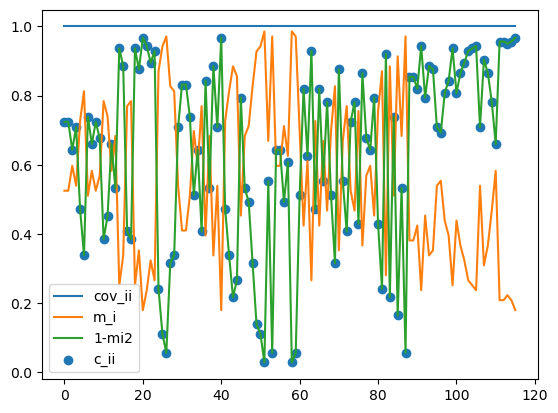

In [22]:
idx = 3
m_i = m[idx]
c_ii = np.diag(c[idx])
cov_ii = np.diag(cov[idx])
plt.scatter(range(len(c_ii)), c_ii, label='c_ii')
plt.plot(cov_ii, label='cov_ii')
plt.plot(m_i, label='m_i')
plt.plot(1-m_i**2, label='1-mi2')
plt.legend()
plt.show()

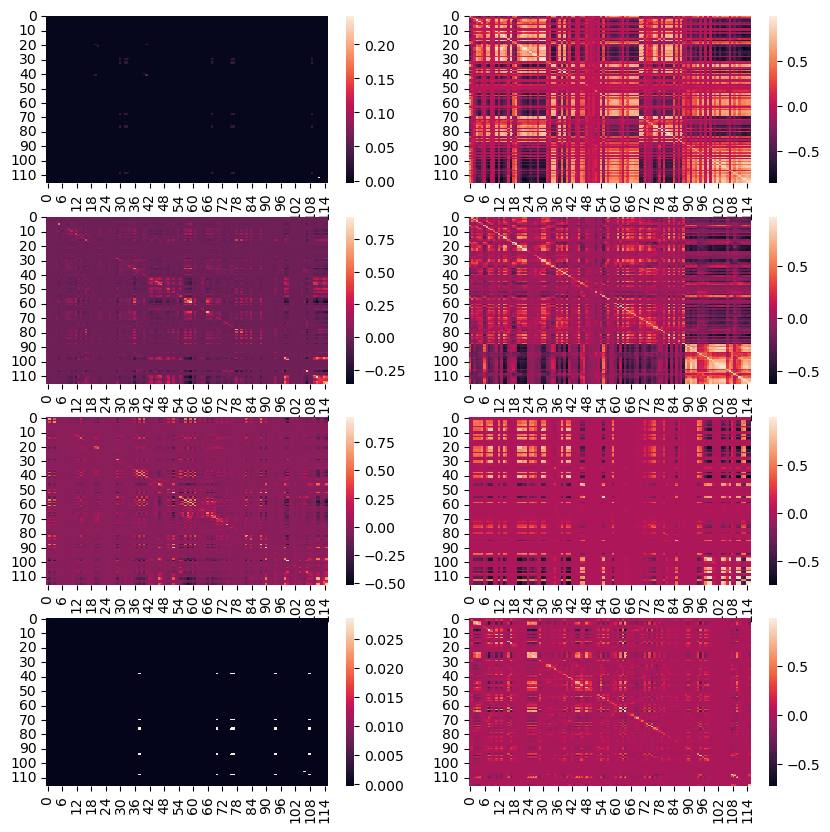

In [31]:
n = 8
fig, axs = plt.subplots(4, n//4, figsize=(10, 10))
for idx in range(n):
    sns.heatmap(c[idx], ax=axs[idx//2, idx%2])

In [32]:
xsg = [i[0] for i in res]
xuni = [i[1] for i in res]

In [35]:
#create a dataframe with subids, xsg and xuni
print(len(trunc_subids), len(xsg), len(xuni))
df = pd.DataFrame({'subid': trunc_subids, 'xsg': xsg, 'xuni': xuni})

88 88 88


In [36]:
df['xuni'].describe()

count    88.000000
mean      1.750915
std       1.682396
min       0.009091
25%       0.542620
50%       1.518587
75%       2.322786
max      11.038409
Name: xuni, dtype: float64

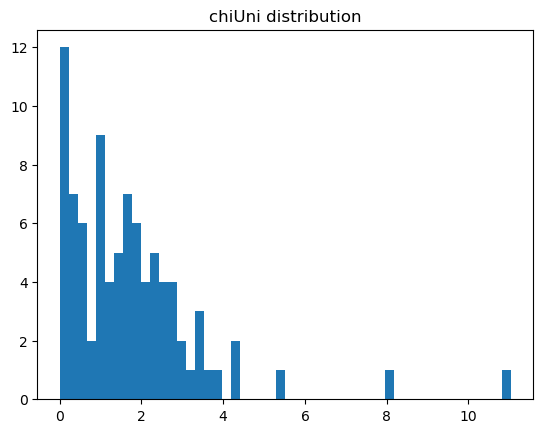

In [37]:
plt.hist(df['xuni'], bins=50)
plt.title('chiUni distribution')
plt.show()

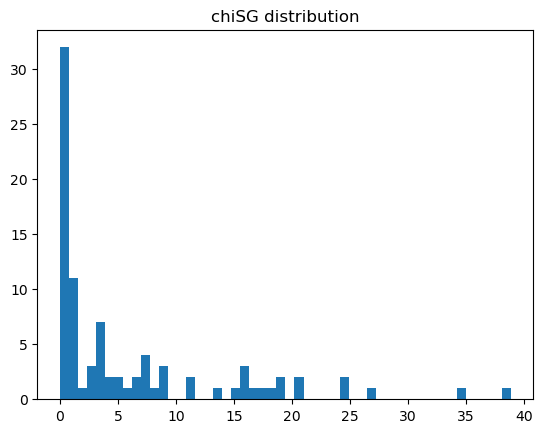

In [59]:
plt.hist(df['xsg'], bins=50)
plt.title('chiSG distribution')
plt.show()

In [62]:
df

,subid,xsg,xuni
0,002_S_0295,0.000914,0.015338
1,002_S_0413,15.279486,3.761792
2,002_S_1261,0.405288,1.091837
3,002_S_1280,6.056955,2.164402
4,002_S_4213,0.776955,0.556464
...,...,...,...
83,136_S_4269,6.686347,2.266596
84,136_S_4433,6.428428,1.883111
85,136_S_4726,0.517088,0.855824
86,136_S_4727,0.024969,0.178519


In [39]:
df.to_csv('data/adni_z_chi.csv', index=False)

In [4]:
J = np.loadtxt(f'data/PMEM/J_adni_z.dat')
h = np.loadtxt(f'data/PMEM/h_adni_z.dat')
print(J.shape, h.shape)

(116, 116) (116,)


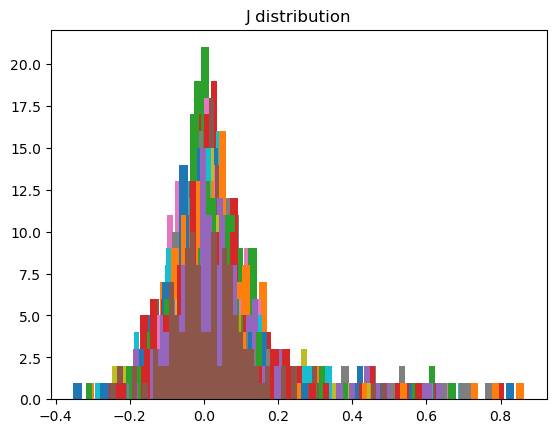

In [8]:
idx = 0
for idx in range(J.shape[0]):
    plt.hist(J[idx], bins=50)
# plt.hist(J[idx], bins=50)
plt.title('J distribution')
plt.show()

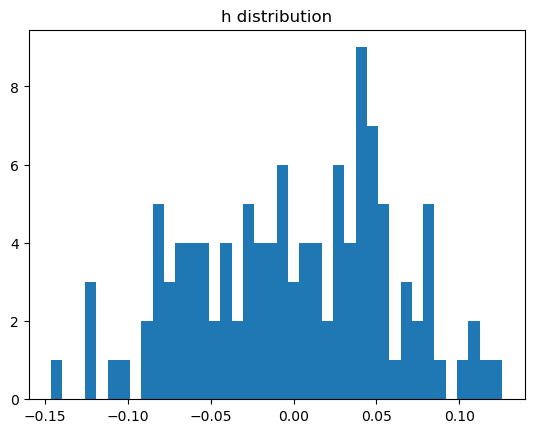

In [12]:
idx = 0
# plt.hist(J[idx], bins=50)
plt.hist(h, bins=40)
plt.title('h distribution')
plt.show()